https://ithelp.ithome.com.tw/articles/10233234  
Day 27 : 股市 K 線 LINE 聊天機器人實作 (功能實作)  
https://ithelp.ithome.com.tw/articles/10241574  

建立bbands教材，詳細說明策略的想法，並實際計算績效
1. 畫出bbands，並且沒有出現空缺
2. 完成不同策略的判斷、並畫出買賣點
3. 分析此策略的績效並改進

<bound method NDFrame.head of              Open   High    Low  Close  Volume
Date                                          
2022-07-20  502.0  503.0  491.5  495.0   36863
2022-07-21  496.0  501.0  494.0  501.0   23893
2022-07-22  505.0  505.0  500.0  503.0   26904
2022-07-25  500.0  503.0  498.0  499.5   16804
2022-07-26  499.5  499.5  491.0  495.0   19524
2022-07-27  494.0  502.0  491.0  502.0   17077>


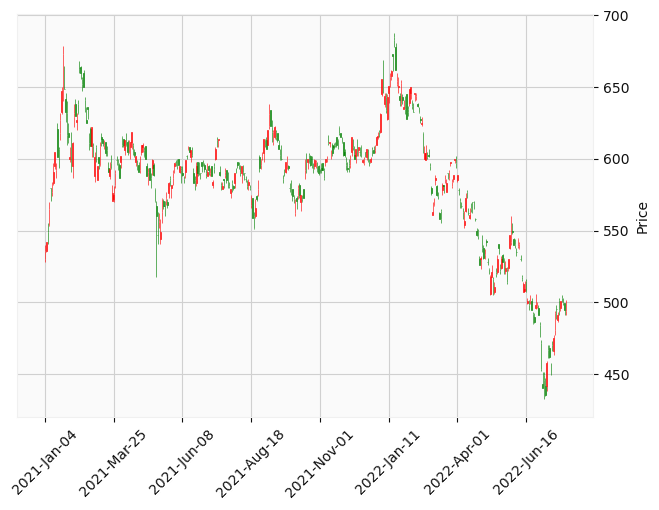

In [2]:
import pandas as pd
import mplfinance as mpf
# 讀取股票檔案，最新100筆資料
SData = pd.read_csv('2330.csv',index_col='Date')
# 更改時間格式
SData.index = pd.DatetimeIndex(SData.index)
print(SData.iloc[-6:,:].head)
mc = mpf.make_marketcolors(up='r', down='g', inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)
mpf.plot(SData, type='candle', style =s)

In [3]:
def BBands(data, period=20, std_num=2):
    
    # 複製一份資料，避免修改原始資料
    res = data.copy(deep=True)

    # 計算中線，也就是二十日 MA
    res['bbands_middle'] = data['Close'].rolling(period).mean()
    
    # 計算標準差
    std = data['Close'].rolling(period).std(ddof=0) 
    
    # 計算上下軌
    res['bbands_upper'] = res['bbands_middle'] + std * std_num 
    res['bbands_lower'] = res['bbands_middle'] - std * std_num

    return res

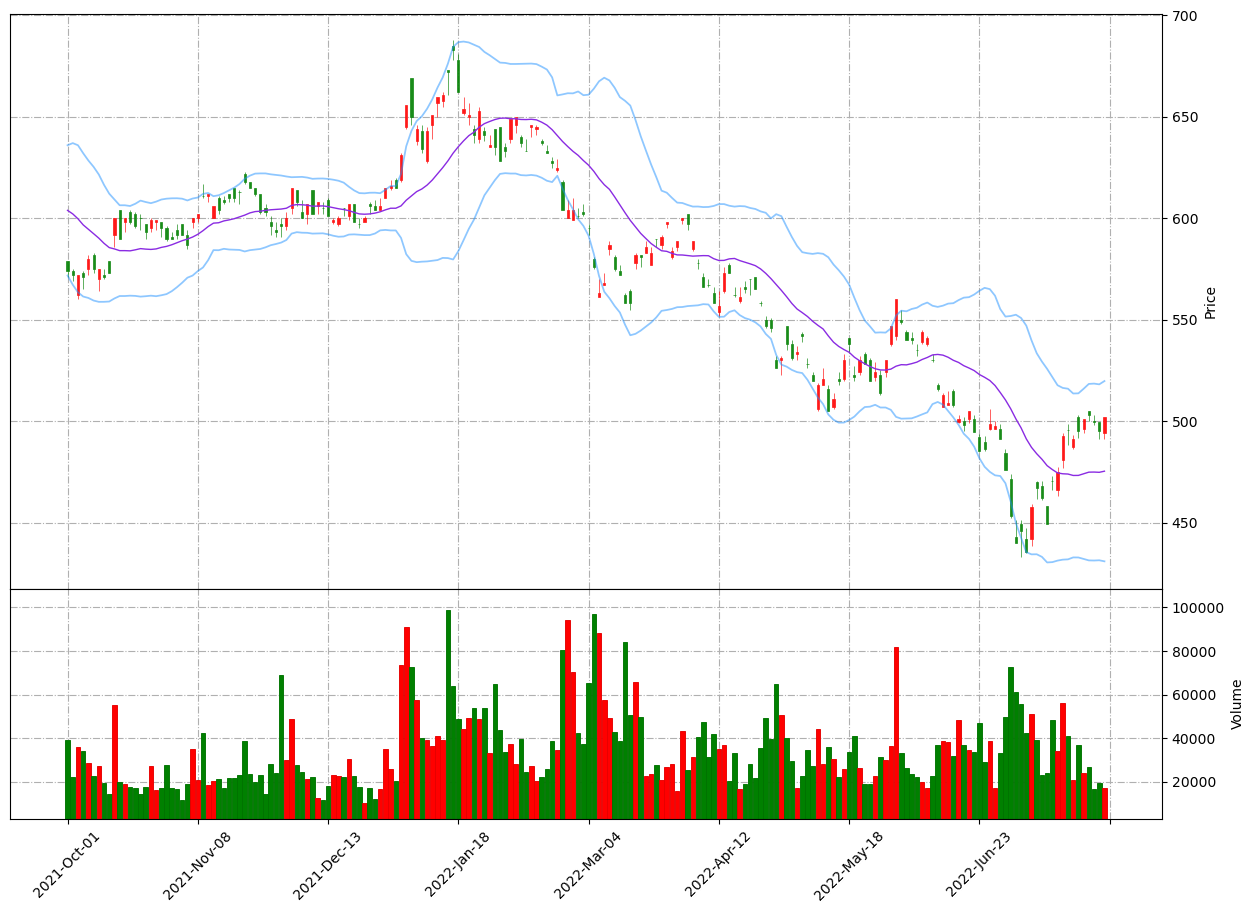

In [4]:
day_num = 200

bbands_data = BBands(SData)
#print(bbands_data)

addplots = [
            mpf.make_addplot(bbands_data['bbands_middle'][-day_num:], panel=0, color='blueviolet', alpha=1
                             , width=1, secondary_y=False),
            mpf.make_addplot(bbands_data['bbands_upper'][-day_num:], color = 'dodgerblue', alpha=0.5),
            mpf.make_addplot(bbands_data['bbands_lower'][-day_num:], color = 'dodgerblue', alpha=0.5)
           ]
# 設置k線圖顏色
my_color = mpf.make_marketcolors(up='red',      # 上漲顏色
                                 down='green',  # 下跌顏色
                                 edge='i',      # 隱藏 K 線邊緣
                                 volume='in',   # 成交量用同樣的顏色
                                 inherit=True)  # 繼承其他參數
# 設置圖型呈現
my_style = mpf.make_mpf_style(gridaxis='both',          # 設置網格
                              gridstyle='-.',           # 設定網格花樣
                              y_on_right=True,          # y 座標放右邊
                              marketcolors=my_color)    # 設定k線圖顏色

kwargs = dict(type = 'candle', 
              figscale = 2, # 設定圖型大小
              style = my_style)

_panel = 2
mpf.plot(SData.iloc[-day_num:,:],
         #mav = [10, 20, 60],
         **kwargs,
         num_panels=_panel,          # 設定總層數
         main_panel=0,               # 設定 K 線圖層數
         volume=True,              # 設定是否繪製成交量 
         volume_panel=_panel - 1,    # 設定成交量層數             
         show_nontrading=False,      # 忽略非交易日
         tight_layout=False,          # 設定布局方式
         addplot = addplots)

In [8]:
#print(SData)
# 新增布林通道後資訊
print(bbands_data.columns)
print(bbands_data)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'bbands_middle',
       'bbands_upper', 'bbands_lower'],
      dtype='object')
             Open   High    Low  Close  Volume  bbands_middle  bbands_upper  \
Date                                                                          
2021-01-04  530.0  540.0  528.0  536.0   39490            NaN           NaN   
2021-01-05  536.0  542.0  535.0  542.0   34839            NaN           NaN   
2021-01-06  555.0  555.0  541.0  549.0   55614            NaN           NaN   
2021-01-07  554.0  570.0  553.0  565.0   53393            NaN           NaN   
2021-01-08  580.0  580.0  571.0  580.0   62957            NaN           NaN   
...           ...    ...    ...    ...     ...            ...           ...   
2022-07-21  496.0  501.0  494.0  501.0   23893        474.050    515.970043   
2022-07-22  505.0  505.0  500.0  503.0   26904        474.875    518.362786   
2022-07-25  500.0  503.0  498.0  499.5   16804        474.925    518.523480   
202

In [ ]:
def bbands_rule(_ticker, buy_point_name='buy_point', 
        bb_period=20, bb_stdnum=2):
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 檢查使否存在要用的指標
    try:
        if not {'bbands_middle', 'bbands_upper', 'bbands_lower'}.issubset(res.columns):
            res = BBands(res, bb_period, bb_stdnum)
    except Exception as e:
        print(e)
        return False

    # 新增一個空行，預設值為零
    res[buy_point_name] = 0

    # 取得 index 值，方便計算使用
    t = res.index

    # 判斷前幾日始否跌破下軌了
    is_lower = False
    is_upper = False

    for i in range(1, len(res)):

        # 計算是否符合做多首要條件
        if res.loc[t[i], 'Close'] < res.loc[t[i], 'bbands_lower']:
            is_lower = True
        elif res.loc[t[i], 'Close'] > res.loc[t[i], 'bbands_middle']:
            is_lower = False

        # 計算是否符合做空首要條件
        if res.loc[t[i], 'Close'] > res.loc[t[i], 'bbands_upper']:
            is_upper = True
        elif res.loc[t[i], 'Close'] < res.loc[t[i], 'bbands_middle']:
            is_upper = False
        
        # 計算做多點
        if is_lower and res.loc[t[i], 'Close'] > res.loc[t[i], 'EMA_' + str(ma_period)] \
                or res.loc[t[i], 'bbands_upper'] > res.loc[t[i - 1], 'bbands_upper'] \
                and res.loc[t[i], 'bbands_middle'] > res.loc[t[i - 1], 'bbands_middle'] \
                and res.loc[t[i], 'bbands_lower'] > res.loc[t[i - 1], 'bbands_lower']:
            
            res.loc[t[i], 'buy_point'] = 1
        
        # 計算做空點
        elif is_upper and res.loc[t[i], 'Close'] < res.loc[t[i], 'EMA_' + str(ma_period)] \
                or res.loc[t[i], 'bbands_upper'] < res.loc[t[i - 1], 'bbands_upper'] \
                and res.loc[t[i], 'bbands_lower'] > res.loc[t[i - 1], 'bbands_lower']:
            
            res.loc[t[i], 'buy_point'] = -1

    return res

In [2]:
def bbands_ema_rule(_ticker, buy_point_name='buy_point', 
        bb_period=20, bb_stdnum=2, ma_period=5):
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)

    # 檢查使否存在要用的指標
    try:
        if not {'bbands_middle', 'bbands_upper', 'bbands_lower'}.issubset(res.columns):
            res = BBands(res, bb_period, bb_stdnum)
        if not {'EMA_' + str(ma_period)}.issubset(res.columns):
            res = EMA(res, ma_period)
    except Exception as e:
        print(e)
        return False

    # 新增一個空行，預設值為零
    res[buy_point_name] = 0

    # 取得 index 值，方便計算使用
    t = res.index

    # 判斷前幾日始否跌破下軌了
    is_lower = False
    is_upper = False

    for i in range(1, len(res)):

        # 計算是否符合做多首要條件
        if res.loc[t[i], 'Close'] < res.loc[t[i], 'bbands_lower']:
            is_lower = True
        elif res.loc[t[i], 'Close'] > res.loc[t[i], 'bbands_middle']:
            is_lower = False

        # 計算是否符合做空首要條件
        if res.loc[t[i], 'Close'] > res.loc[t[i], 'bbands_upper']:
            is_upper = True
        elif res.loc[t[i], 'Close'] < res.loc[t[i], 'bbands_middle']:
            is_upper = False
        
        # 計算做多點
        if is_lower and res.loc[t[i], 'Close'] > res.loc[t[i], 'EMA_' + str(ma_period)] \
                or res.loc[t[i], 'bbands_upper'] > res.loc[t[i - 1], 'bbands_upper'] \
                and res.loc[t[i], 'bbands_middle'] > res.loc[t[i - 1], 'bbands_middle'] \
                and res.loc[t[i], 'bbands_lower'] > res.loc[t[i - 1], 'bbands_lower']:
            
            res.loc[t[i], 'buy_point'] = 1
        
        # 計算做空點
        elif is_upper and res.loc[t[i], 'Close'] < res.loc[t[i], 'EMA_' + str(ma_period)] \
                or res.loc[t[i], 'bbands_upper'] < res.loc[t[i - 1], 'bbands_upper'] \
                and res.loc[t[i], 'bbands_lower'] > res.loc[t[i - 1], 'bbands_lower']:
            
            res.loc[t[i], 'buy_point'] = -1

    return res